<a href="https://colab.research.google.com/github/notanikdey/SummerSchool/blob/main/dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json here manually

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anikdey23","key":"276468e06081ec71a35ec6aeb0dcb62d"}'}

In [4]:
import os
import zipfile

# Make .kaggle directory and move the file
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c ssd-3-l-dog-breed-classification

 92% 691M/753M [00:04<00:01, 42.9MB/s]
100% 753M/753M [00:04<00:00, 192MB/s] 


In [6]:
import zipfile

zip_path = "/content/ssd-3-l-dog-breed-classification.zip"
extract_path = "/content/dog_breed_classification"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [7]:
os.listdir(extract_path)

['dog_breed_competition']

Original size: (700, 544)


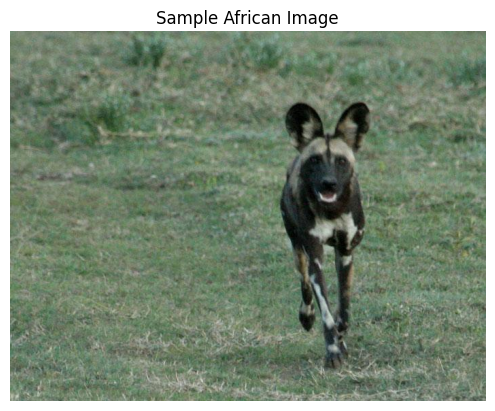

In [11]:
from PIL import Image

img_path = "dog_breed_classification/dog_breed_competition/train/african/african_00000.jpg"
img = Image.open(img_path)

print("Original size:", img.size)  # (width, height)

plt.imshow(img)
plt.title("Sample African Image")
plt.axis('off')
plt.show()


In [ ]:
from collections import Counter

folder = ""
size_counts = Counter()

for class_dir in os.listdir(folder):
    class_path = os.path.join(folder, class_dir)
    for fname in os.listdir(class_path)[:100]:  # check first 100 images per class
        img_path = os.path.join(class_path, fname)
        try:
            img = Image.open(img_path)
            size_counts[img.size] += 1
        except:
            continue

print("Most common image sizes:")
for size, count in size_counts.most_common(10):
    print(size, "→", count, "images")


In [12]:
base_path = "/content/dog_breed_classification/dog_breed_competition"

In [16]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.Resize((256,256)),  # Resize short edge to 256
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # Random crop & scale
    transforms.RandomHorizontalFlip(p=0.5),  # Flipping makes sense for animals
    transforms.RandomRotation(10),  # Small rotations for viewpoint variation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Lighting variation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Subtle 3D distortions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)



In [43]:
#Model Definition using ResNet
from torchvision import models
def get_resnet_model(num_classes=157, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    #Replacing the last fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)
    return model

In [36]:
model = get_resnet_model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [37]:
next(model.parameters()).device

device(type='cpu')

In [38]:
#Initializing loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

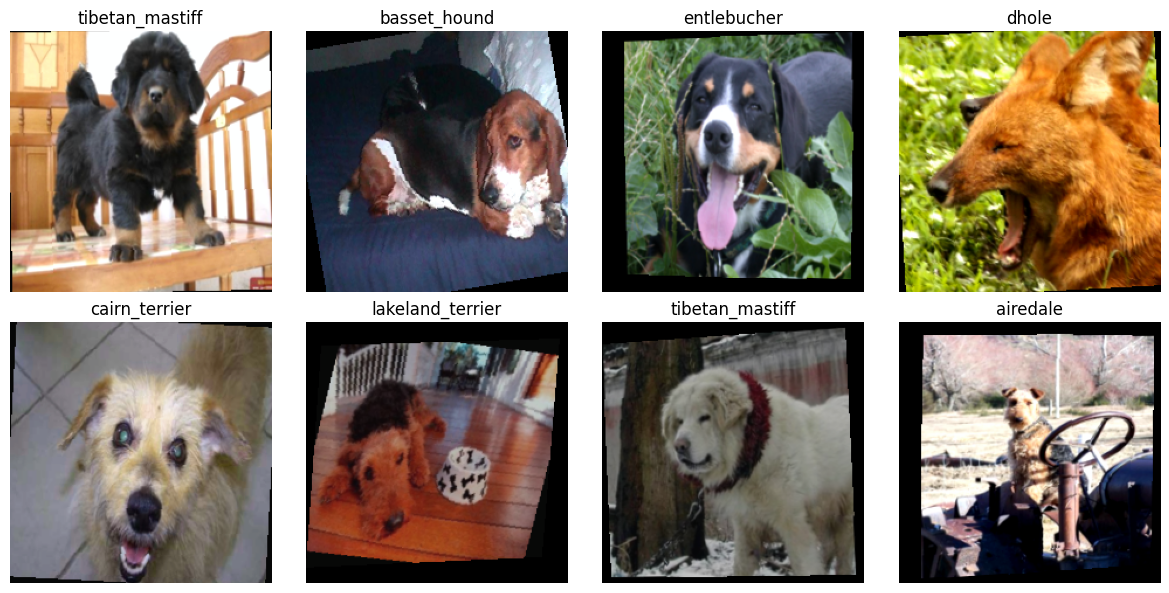

In [39]:
#Visualizing a batch

images, labels = next(iter(train_loader))

#Denormalize to [0, 1] range for visualization
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = img_tensor.numpy().transpose((1, 2, 0))  # CxHxW → HxWxC
    img = std * img + mean  # De-normalize
    img = np.clip(img, 0, 1)  # Ensure within [0,1] for display

    return img

class_names = train_dataset.classes

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(denormalize(images[i]))
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import accuracy_score
import time

In [41]:
#Training

num_epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
  start = time.time()

  #### TRAINING ####
  model.train()
  running_loss = 0.0

  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

  avg_train_loss = running_loss / len(train_loader) #for each batch/iteration
  train_losses.append(avg_train_loss)

  #### VALIDATION ####
  model.eval()
  all_preds, all_labels = [], []

  with torch.inference_mode():
      for images, labels in val_loader:
          images = images.to(device)
          outputs = model(images)
          preds = outputs.argmax(dim=1).cpu().numpy()

          all_preds.extend(preds)
          all_labels.extend(labels.numpy())

  val_acc = accuracy_score(all_labels, all_preds)
  val_accuracies.append(val_acc)

  print(f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Accuracy: {val_acc*100:.2f}% | "
        f"Time: {time.time() - start:.1f}s")


KeyboardInterrupt: 

In [ ]:
#Plotting the Losses
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

#Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

#Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in val_accuracies], marker='o', color='green')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()